In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from google.cloud import storage
import os
import io
from datetime import datetime
from tqdm import tqdm

In [2]:
spark = SparkSession.builder.appName('bigdata_taxi').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/05 18:18:34 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/03/05 18:18:34 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/03/05 18:18:34 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/03/05 18:18:34 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.dataproc.sql.joinConditionReorder.enabled', 'true'),
 ('spark.dataproc.sql.local.rank.pushdown.enabled', 'true'),
 ('spark.yarn.historyServer.address',
  'hub-hub-msca-bdp-dphub-student-namanmehta-m:18080'),
 ('spark.yarn.unmanagedAM.enabled', 'true'),
 ('spark.driver.appUIAddress',
  'http://hub-hub-msca-bdp-dphub-student-namanmehta-m.c.msca-bdp-student-ap.internal:39823'),
 ('spark.sql.autoBroadcastJoinThreshold', '43m'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.eventLog.dir',
  'gs://dataproc-temp-us-central1-635155370842-uzamlpgc/ea81bdd7-48f3-4a5a-bb35-159fe9e0b80c/spark-job-history'),
 ('spark.metrics.namespace',
  'app_name:${spark.app.name}.app_id:${spark.app.id}'),
 ('spark.executor.memory', '4g'),
 ('spark.dataproc.sql.optimizer.leftsemijoin.conversion.enabled', 'true'),
 ('spark.had

In [3]:
bucket_name = 'msca-bdp-student-gcs'
storage_client = storage.Client()
from_date = datetime.strptime('2018-01-01','%Y-%m-%d')
till_date = datetime.strptime('2022-12-31','%Y-%m-%d')
folder_name = 'Group8_Project_Data'

req_cols = ['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

for blob in tqdm(storage_client.list_blobs(bucket_name, prefix = folder_name)):
    if str(blob.name).split(".")[-1] == 'parquet':
        file_month = ''.join(list(filter(str.isdigit, blob.name))[1:])
        if datetime.strptime(file_month, '%Y%m') >= from_date and datetime.strptime(file_month, '%Y%m') <= till_date:
            if datetime.strptime(file_month, '%Y%m') == from_date:
                data = spark.read.parquet(f'gs://{bucket_name}/{blob.name}', inferSchema=True, header=True)
                data = data.select(*req_cols)
            else:
                df_month = spark.read.parquet(f'gs://{bucket_name}/{blob.name}', inferSchema=True, header=True)
                data = data.union(df_month.select(*req_cols))
                
location_mapping = spark.read.csv(f'gs://{bucket_name}/{folder_name}/tlc_trip_record_yellow_taxi/taxi_zone_lookup.csv', inferSchema = True, header = True)

170it [00:18,  9.24it/s]                                                        


In [4]:
#Create another dataframe to process
df1 = data.alias('df1')

In [5]:
df1 = df1.fillna(0, subset=['airport_fee'])
df1 = df1.na.drop("any")
#df2.select([(count(when(df2[c].isNull(), c))/count(df2[c])).alias(c) for c in df2.columns]).show()

In [6]:
double_cols = [item[0] for item in df1.dtypes if item[1] == 'double']
for double_col in double_cols:
    df1 = df1.filter(df1[double_col]>0)
#df2.describe().show()

In [7]:
new_column_name_list = list(map(lambda x: 'PU' + x , location_mapping.columns))
location_mapping_pu = location_mapping.toDF(*new_column_name_list)

df1 = df1.join(location_mapping_pu,df1.PULocationID == location_mapping_pu.PULocationID,"left").drop('PULocationID','LocationID')

In [8]:
new_column_name_list = list(map(lambda x: 'DO' + x , location_mapping.columns))
location_mapping_do = location_mapping.toDF(*new_column_name_list)

df1 = df1.join(location_mapping_do,df1.DOLocationID == location_mapping_do.DOLocationID,"left").drop('DOLocationID','LocationID','PULocationID')
# df1.show(2)

In [9]:
from pyspark.sql.functions import *

def extract_date_info_spark(df, date_column, prefix):
    date_df = df.withColumn(prefix + "_" + "datetime", to_timestamp(col(date_column))) \
                .withColumn(prefix + "_" + "year", year(col(date_column))) \
                .withColumn(prefix + "_" + "month", month(col(date_column))) \
                .withColumn(prefix + "_" + "day", dayofmonth(col(date_column))) \
                .withColumn(prefix + "_" + "hour", hour(col(date_column))) \
                .withColumn(prefix + "_" + "day_of_week", dayofweek(col(date_column))) \
                .withColumn(prefix + "_" + "day_of_year", dayofyear(col(date_column))) \
                .withColumn(prefix + "_" + "week_of_year", weekofyear(col(date_column))) \
                .withColumn(prefix + "_" + "is_month_start", (dayofmonth(col(date_column)) == lit(1)))\
                .withColumn(prefix + "_" + 'is_month_end', when(col(date_column) == last_day(col(date_column)), 1).otherwise(0))\
                .withColumn(prefix + "_" + "is_year_start", (dayofyear(col(date_column)) == lit(1)))\
                .withColumn(prefix + "_" + "is_year_end", (dayofyear(col(date_column)) == lit(365)))\
                .withColumn(prefix + "_" + 'is_weekday', when(dayofweek(col(date_column)).isin([2,3,4,5,6]), 1).otherwise(0))\
                .withColumn(prefix + "_" + 'is_weekend', when(dayofweek(col(date_column)).isin([1,7]), 1).otherwise(0))
    
    pickup_columns = [c for c in date_df.columns if c.startswith(prefix)]
    date_df = date_df.select(*pickup_columns)
    
    for c in date_df.columns:
        if c != prefix + "_" + "datetime":
            date_df = date_df.withColumn(c,col(c).cast("double"))
                            
    return date_df

In [23]:
df1 = df1.withColumn("tpep_pickup_datetime", date_trunc("hour", to_timestamp(col("tpep_pickup_datetime"))))
df1 = df1.withColumn("tpep_dropoff_datetime", date_trunc("hour", to_timestamp(col("tpep_dropoff_datetime"))))

df2 = df1.groupby(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PUBorough', 'PUZone', 'PUservice_zone', 'DOBorough', 'DOZone', 'DOservice_zone']).count().orderBy('count', ascending = False)
# df2.show(20)

In [24]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute,concat,lit
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer,OneHotEncoder

df2 = df2.filter((to_date(df2.tpep_pickup_datetime) >= from_date) & (to_date(df2.tpep_pickup_datetime) <= till_date))
df2 = df2.withColumn("VendorID", df2["VendorID"].cast(StringType()))

In [25]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute,concat,lit
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer,OneHotEncoder

df2 = df2.filter((to_date(df2.tpep_pickup_datetime) >= from_date) & (to_date(df2.tpep_pickup_datetime) <= till_date))

df2 = df2.withColumn("VendorID", df2["VendorID"].cast(StringType()))

pickup_date_info_df2 = extract_date_info_spark(df2, 'tpep_pickup_datetime', 'pickup')
dropoff_date_info_df2 = extract_date_info_spark(df2, 'tpep_dropoff_datetime', 'dropoff')
df2 = df2.join(pickup_date_info_df2, df2.tpep_pickup_datetime == pickup_date_info_df2.pickup_datetime, how = 'left').dropDuplicates()

#df2 = df2.join(dropoff_date_info_df2, df2.tpep_dropoff_datetime == dropoff_date_info_df2.dropoff_datetime, how = 'left').dropDuplicates()

df2 = df2.drop(*['tpep_pickup_datetime','tpep_dropoff_datetime'])
                     
df2 = df2.withColumn("season",
                    when((df2.pickup_month >= 3) & (df2.pickup_month <= 5), "Spring")
                    .when((df2.pickup_month >= 6) & (df2.pickup_month <= 8), "Summer")
                    .when((df2.pickup_month >= 9) & (df2.pickup_month <= 10), "Fall")
                    .when((df2.pickup_month >= 11) | (df2.pickup_month <= 2), "Winter")
                    .otherwise("Unknown"))

df2 = df2.withColumn('is_peak_hour', 
                   when((df2.pickup_hour >= 6) & (df2.pickup_hour <= 10) |
                        (df2.pickup_hour >= 16) & (df2.pickup_hour <= 20) , 1)
                   .otherwise(0))

df2 = df2.na.drop("any")

In [ ]:
%%time
from pyspark.sql.functions import concat, lit, udf
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

#convert relevant categorical into one hot encoded
onehot_list = ['VendorID', 'PUBorough', 'PUservice_zone','PUZone','season','DOBorough', 'DOZone', 'DOservice_zone']
inputs = []
encoder = []
for column in onehot_list:
    df2 = df2.withColumn(column, concat(column, lit('_'+column)))
    input_ = StringIndexer(inputCol = column, outputCol = column + 'Idx').setHandleInvalid("skip")
    inputs.append(input_)

encoder = OneHotEncoder(inputCols = [input_.getOutputCol() for input_ in inputs], outputCols = [column+'_vec' for column in onehot_list])

#run it through a pipeline
pipeline = Pipeline(stages=inputs+[encoder])
encodedData = pipeline.fit(df2).transform(df2)

# encodedData.show(5)

23/03/05 19:46:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1439.5 KiB
23/03/05 19:46:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1546.4 KiB
23/03/05 19:47:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1439.5 KiB
23/03/05 19:47:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1552.3 KiB
23/03/05 19:47:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1563.8 KiB
23/03/05 19:47:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1439.5 KiB


In [ ]:
cols_to_drop = onehot_list+[input_.getOutputCol() for input_ in inputs]
encodedData = encodedData.drop(*cols_to_drop)
encodedData.printSchema()

In [ ]:
#gather feature vector and identify features
assembler = VectorAssembler(inputCols = encodedData.drop('pickup_datetime','count').columns, \
                            outputCol = 'features')

encodedDataAssembled = assembler.transform(encodedData)
encodedDataAssembled.printSchema()

In [ ]:
train_df = encodedDataAssembled.filter((encodedDataAssembled.pickup_datetime < '2022-08-01'))
test_df = encodedDataAssembled.filter((encodedDataAssembled.pickup_datetime >= '2022-08-01'))
encodedDataAssembled = encodedDataAssembled.drop('pickup_datetime')

In [17]:
print((train_df.count(), len(train_df.columns)))
print((test_df.count(), len(test_df.columns)))

23/03/05 18:29:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1313.3 KiB
23/03/05 18:29:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1445.1 KiB


(433542, 38)


23/03/05 18:30:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1445.1 KiB
23/03/05 18:30:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1313.3 KiB


(33438, 38)


In [ ]:
%%time
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(featuresCol = 'features', labelCol='count')
model = rf.fit(train_df)

predictions = model.transform(train_df)

evaluator = RegressionEvaluator(labelCol="count", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol='count', predictionCol='prediction', metricName='r2')
rmse = evaluator.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
print("Training Summary:")
print(f"RMSE = {rmse}")
print(f'R-squared = {r2}')

print("-"*100)

# Make predictions.
predictions = model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="count", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol='count', predictionCol='prediction', metricName='r2')
rmse = evaluator.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
print("Testing Summary:")
print(f"RMSE = {rmse}")
print(f'R-squared = {r2}')

Training Summary:
RMSE = 0.6819975320677577
R-squared = 0.11772231490784613
----------------------------------------------------------------------------------------------------


Testing Summary:
RMSE = 0.8534133572346412
R-squared = 0.13071289984003986
CPU times: user 669 ms, sys: 133 ms, total: 802 ms
Wall time: 4min 59s


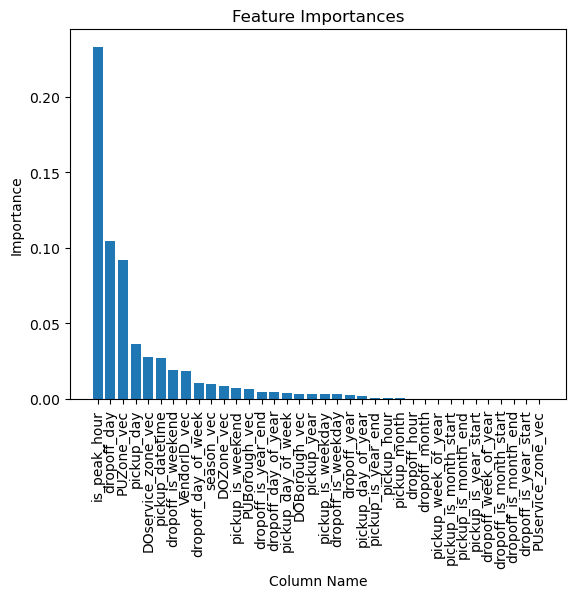

In [22]:
import matplotlib.pyplot as plt

# Get the feature importances from the model
importances = model.featureImportances
column_names = train_df.columns

# create a list of (column name, importance) tuples
importances = list(zip(train_df.drop(*['count','features']).columns, model.featureImportances))

# sort the list by importance, in descending order
importances.sort(key=lambda x: x[1], reverse=True)

# extract the column names and importances as separate lists
names, values = zip(*importances)

# create a bar plot of the importances
plt.bar(names, values)

# set the plot title and axis labels
plt.title('Feature Importances')
plt.xlabel('Column Name')
plt.ylabel('Importance')

# rotate the x-axis labels to avoid overlapping
plt.xticks(rotation=90)

# display the plot
plt.show()

In [20]:
%%time
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='count')
lrm = lr.fit(train_df)

#model summary
print("Training Summary:")
print(f"RMSE: {lrm.summary.rootMeanSquaredError}")
print(f"r2: {lrm.summary.r2}")

print("-"*100)
# Make predictions.
predictions = lrm.transform(test_df)

# Select (predictio`n, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="count", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
print("Testing Summary:")
print(f"RMSE = {rmse}")
print(f'R-squared = {r2}')

23/03/05 18:33:18 WARN org.apache.spark.ml.util.Instrumentation: [b101899d] regParam is zero, which might cause numerical instability and overfitting.
23/03/05 18:33:27 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/05 18:33:27 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/03/05 18:33:27 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/03/05 18:33:27 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/03/05 18:33:27 WARN org.apache.spark.ml.util.Instrumentation: [b101899d] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Training Summary:
RMSE: 0.6945692232747886
r2: 0.1334773422862765
----------------------------------------------------------------------------------------------------
Testing Summary:


RMSE on test data: 0.9247098475198083
CPU times: user 380 ms, sys: 81.5 ms, total: 462 ms
Wall time: 2min 21s
